# Self-Play: The Heart of AlphaZero

**Self-play** is the core training mechanism in AlphaZero where the AI plays against itself to generate training data and improve over time. This notebook explains how self-play works and how it combines MCTS and neural networks to create a continuously improving system.

## Overview

AlphaZero doesn't learn from human expert games. Instead, it:
1. **Plays games against itself** using MCTS guided by a neural network
2. **Records training examples** from each game (states, MCTS policies, outcomes)
3. **Trains the neural network** on these examples to improve predictions
4. **Repeats** the process, getting progressively stronger

This creates a virtuous cycle

<!-- better network → better MCTS → better training data → better network. -->

```mermaid
---
config:
  theme: 'base'
  themeVariables:
    primaryColor: '#ffffff'
    primaryTextColor: '#4D5461'
    primaryBorderColor: '#096bda11'
    lineColor: '#096bda'
    secondaryColor: '#ffffff84'
    secondaryTextColor: '#4D5461'
    tertiaryColor: '#4d546110'
    tertiaryTextColor: '#4D5461'
---
stateDiagram-v2
    s1: Better Neural Network
    s2: Better MCTS
    s3: Better Training Data

    s1 --> s2
    s2 --> s3
    s3 --> s1
```

In [1]:
import numpy as np


class MCTSNode:
    """A node in the Monte Carlo Tree Search tree"""

    def __init__(self, state, parent=None, action=None, prior=0):
        self.state = state  # Game state (tuple of board, player)
        self.parent = parent  # Parent node
        self.action = action  # Action that led to this node
        self.children = {}  # Dict mapping actions to child nodes

        # MCTS statistics
        self.visit_count = 0  # N(s,a): number of visits
        self.value_sum = 0.0  # W(s,a): sum of values from simulations
        self.prior = prior  # P(s,a): neural network prior probability

    def is_expanded(self):
        """Check if this node has children"""
        return len(self.children) > 0

    def value(self):
        """Average value Q(s,a) = W(s,a) / N(s,a)"""
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def q_from_parent_view(self):
        """Return Q value from parent's perspective (negated)"""
        return -self.value()

    def ucb_score(self, c_puct=1.0):
        """
        Calculate PUCT score: Q(s,a) + U(s,a)
        U(s,a) = c_puct * P(s,a) * sqrt(N(parent)) / (1 + N(s,a))
        """
        parent_N = 1 + (self.parent.visit_count if self.parent else 0)
        U = c_puct * self.prior * (np.sqrt(parent_N) / (1 + self.visit_count))
        Q = self.q_from_parent_view()
        return Q + U

    def select_child(self, c_puct=1.0):
        """Select child with maximum PUCT score"""
        return max(self.children.values(), key=lambda ch: ch.ucb_score(c_puct))

    def expand(self, game, action_probs):
        """Create child nodes for all legal actions"""
        for action, prob in action_probs:
            if action not in self.children:
                new_state = game.copy()
                new_state.make_move(action)
                self.children[action] = MCTSNode(
                    state=new_state.state(), parent=self, action=action, prior=prob
                )

    def backup(self, value):
        """Propagate value up the tree (negating at each level)"""
        self.visit_count += 1
        self.value_sum += value
        if self.parent:
            self.parent.backup(-value)  # Negate for opponent's perspective


class AlphaZeroMCTS:
    """MCTS search guided by a neural network"""

    def __init__(self, game, model, c_puct=1.0, num_simulations=100):
        self.game = game
        self.model = model
        self.c_puct = c_puct
        self.num_simulations = num_simulations

    def search(self, root_state):
        """Run MCTS simulations from root_state and return root node"""
        root = MCTSNode(root_state)

        # Expand root with Dirichlet noise for exploration
        game_copy_root = self.game.copy()
        if not game_copy_root.over():
            v_root, policy_root = self.model.predict(game_copy_root)
            legal = game_copy_root.valid_moves()
            probs = [(a, policy_root[a]) for a in legal]
            s = sum(p for _, p in probs)
            if s > 0:
                probs = [(a, p / s) for a, p in probs]
            # Add Dirichlet noise to root for exploration
            if probs:
                alpha, eps = 0.3, 0.25
                noise = np.random.dirichlet([alpha] * len(probs))
                probs = [
                    (a, (1 - eps) * p + eps * n) for (a, p), n in zip(probs, noise)
                ]
            root.expand(game_copy_root, probs)

        # Run simulations
        for _ in range(self.num_simulations):
            node = root
            game_copy = self.game.copy()

            # Selection: traverse tree using PUCT
            while node.is_expanded() and not game_copy.over():
                node = node.select_child(self.c_puct)
                game_copy.make_move(node.action)

            # Expansion & Evaluation
            if not game_copy.over():
                v, policy = self.model.predict(game_copy)
                legal = game_copy.valid_moves()
                probs = [(a, policy[a]) for a in legal]
                s = sum(p for _, p in probs)
                if s > 0:
                    probs = [(a, p / s) for a, p in probs]
                node.expand(game_copy, probs)
                node.backup(v)
            else:
                # Terminal node: use game outcome
                terminal_v = game_copy.score() * game_copy.current_player
                node.backup(terminal_v)

        return root

    def get_action_probabilities(self, root_state, temperature=1.0):
        """
        Get move probabilities from MCTS visit counts

        Args:
            temperature: Controls randomness
                - temp=1.0: proportional to visit counts
                - temp=0.0: deterministic (pick most visited)
        """
        root = self.search(root_state)

        actions = []
        visit_counts = []

        for action, child in root.children.items():
            actions.append(action)
            visit_counts.append(child.visit_count)

        if temperature == 0:
            # Greedy: pick best action
            best_action_idx = np.argmax(visit_counts)
            probs = np.zeros(len(actions))
            probs[best_action_idx] = 1.0
        else:
            # Softmax with temperature
            visit_counts = np.array(visit_counts)
            visit_counts = visit_counts ** (1.0 / temperature)
            probs = visit_counts / np.sum(visit_counts)

        return actions, probs


print("✓ MCTS classes defined")

✓ MCTS classes defined


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    """Residual block with skip connection"""

    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Skip connection
        out = F.relu(out)
        return out


class AlphaZeroNet(nn.Module):
    """Neural network with policy and value heads"""

    def __init__(self, game_channels=2, num_res_blocks=4, action_size=9, board_size=3):
        super().__init__()
        self.num_channels = 64

        # Initial convolution
        self.conv_input = nn.Conv2d(
            game_channels, self.num_channels, kernel_size=3, padding=1, bias=False
        )
        self.bn_input = nn.BatchNorm2d(self.num_channels)

        # Residual tower
        self.res_blocks = nn.ModuleList(
            [ResidualBlock(self.num_channels) for _ in range(num_res_blocks)]
        )

        # Policy head: predicts move probabilities
        self.p_conv = nn.Conv2d(self.num_channels, 2, kernel_size=1, bias=False)
        self.p_bn = nn.BatchNorm2d(2)
        self.p_fc = nn.Linear(2 * board_size * board_size, action_size)

        # Value head: predicts position evaluation
        self.v_conv = nn.Conv2d(self.num_channels, 1, kernel_size=1, bias=False)
        self.v_bn = nn.BatchNorm2d(1)
        self.v_fc1 = nn.Linear(1 * board_size * board_size, 64)
        self.v_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # x: (Batch, Channels, Height, Width)
        x = F.relu(self.bn_input(self.conv_input(x)))

        # Residual tower
        for res_block in self.res_blocks:
            x = res_block(x)

        # Policy head
        p = F.relu(self.p_bn(self.p_conv(x)))
        p = p.view(p.size(0), -1)  # Flatten
        policy_logits = self.p_fc(p)

        # Value head
        v = F.relu(self.v_bn(self.v_conv(x)))
        v = v.view(v.size(0), -1)  # Flatten
        v = F.relu(self.v_fc1(v))
        v = torch.tanh(self.v_fc2(v))  # Value in [-1, 1]

        return v.squeeze(-1), policy_logits


class AlphaZeroModel:
    """Wrapper for neural network with training and inference"""

    def __init__(self, board_size=3, action_size=9, learning_rate=0.001):
        self.board_size = board_size
        self.action_size = action_size
        self.net = AlphaZeroNet(action_size=action_size, board_size=board_size)
        self.optimizer = torch.optim.AdamW(
            self.net.parameters(), lr=learning_rate, weight_decay=1e-4
        )
        self.training_data = []

    def encode_state(self, game):
        """
        Convert game state to network input [2, board_size, board_size]
        Channel 0: current player's pieces
        Channel 1: opponent's pieces
        """
        if hasattr(game, "board") and hasattr(game, "current_player"):
            board = np.array(game.board).reshape(self.board_size, self.board_size)
            cur = game.current_player
        else:
            # Stored (state, player) pair
            board = np.array(game[0]).reshape(self.board_size, self.board_size)
            cur = game[1]

        current_plane = (board == cur).astype(np.float32)
        opponent_plane = (board == -cur).astype(np.float32)
        return np.stack([current_plane, opponent_plane], axis=0)

    @torch.no_grad()
    def predict(self, game):
        """Get value and policy predictions for a game state"""
        self.net.eval()
        state = self.encode_state(game)
        x = torch.from_numpy(state).unsqueeze(0)  # Add batch dimension
        value, policy_logits = self.net(x)

        value = float(value[0])
        policy = F.softmax(policy_logits[0], dim=0).numpy()
        return value, policy

    def add_training_data(self, state, action_probs, value):
        """Add a training example to the replay buffer"""
        self.training_data.append((state, action_probs, value))
        # Keep buffer size manageable
        if len(self.training_data) > 50000:
            self.training_data = self.training_data[-50000:]

    def train(self, batch_size=64, epochs=10):
        """Train the network on collected self-play data"""
        if len(self.training_data) < batch_size:
            return

        self.net.train()

        # Prepare training batch
        states, values, policies = [], [], []
        for state, action_probs, value in self.training_data:
            states.append(self.encode_state(state))
            values.append(value)

            # Convert action_probs dict to array
            if isinstance(action_probs, dict):
                policy = np.zeros(self.action_size, dtype=np.float32)
                for action, prob in action_probs.items():
                    policy[action] = prob
            else:
                policy = np.array(action_probs, dtype=np.float32)
            policies.append(policy)

        states = torch.from_numpy(np.array(states))
        values = torch.tensor(values, dtype=torch.float32)
        policies = torch.from_numpy(np.array(policies))

        # Training loop
        dataset_size = len(states)
        for epoch in range(epochs):
            indices = torch.randperm(dataset_size)
            for i in range(0, dataset_size, batch_size):
                batch_indices = indices[i : i + batch_size]
                batch_states = states[batch_indices]
                batch_values = values[batch_indices]
                batch_policies = policies[batch_indices]

                # Forward pass
                pred_values, pred_logits = self.net(batch_states)

                # Loss computation
                value_loss = F.mse_loss(pred_values, batch_values)
                policy_loss = (
                    -torch.sum(batch_policies * F.log_softmax(pred_logits, dim=1))
                    / batch_size
                )
                total_loss = value_loss + policy_loss

                # Backward pass
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()


print("✓ Neural network classes defined")

✓ Neural network classes defined


### The Loop
```mermaid
---
config:
  theme: 'base'
  themeVariables:
    primaryColor: '#ffffff'
    primaryTextColor: '#4D5461'
    primaryBorderColor: '#096bda11'
    lineColor: '#096bda'
    secondaryColor: '#ffffff84'
    secondaryTextColor: '#4D5461'
    tertiaryColor: '#4d546110'
    tertiaryTextColor: '#4D5461'
---
graph TD
    A[Initialize Game] --> B[MCTS Search]
    B --> C[Get Move Probabilities]
    C --> D[Sample Action]
    D --> E[Make Move]
    E --> F{Game Over?}
    F -->|No| B
    F -->|Yes| G[Record Game Outcome]
    G --> H[Create Training Examples]
    H --> I[Train Network]
    I --> A
```

Note: The diagram above illustrates the self-play loop where the agent continuously plays games against itself, collects data, and trains its neural network to improve performance over time. Self-play and Neural Network Training could be done parallely in practice for efficiency. For the purpose of clarity, they are shown sequentially here.

## Advanced Techniques

Before diving into the full self-play implementation, let's understand some critical techniques that make AlphaZero training effective:

1. **Temperature**: Controls exploration vs exploitation during move selection
2. **Dirichlet Noise**: Adds randomness at the root to ensure diverse openings
3. **Replay Buffer**: Stores and reuses training examples across iterations
4. **Data Augmentation**: Multiplies training data using symmetries

These techniques are essential for stable learning and preventing overfitting.

### 1. Temperature: Exploration vs Exploitation

**Temperature** $\tau$ controls how deterministically we select moves from MCTS visit counts.


Temperature controls exploration vs exploitation:
- **High temperature (1.0)**: Early game, explore different openings
- **Low temperature (0.0)**: Late game, play the best move deterministically
- We typically use temperature 1.0 for the first 3-5 moves, then switch to 0.0, in the case of Tic-Tac-Toe. Other games may require different schedules.

Given visit counts $N(s,a)$ for each action $a$:

$$\pi(a|s) = \frac{N(s,a)^{1/\tau}}{\sum_b N(s,b)^{1/\tau}}$$

Temperature does not have an upper bound, but values above 1.0 are rarely used in practice. This is same temperature concept used in LLMs for sampling.

**Temperature Values**

- **$\tau = 1.0$** (high): Probability proportional to visit counts
  - Explores multiple promising moves
  - Used in opening moves to build diverse opening book
  
- **$\tau = 0.0$** (low): Deterministic selection
  - Always picks the most-visited move
  - Used in critical positions and endgame



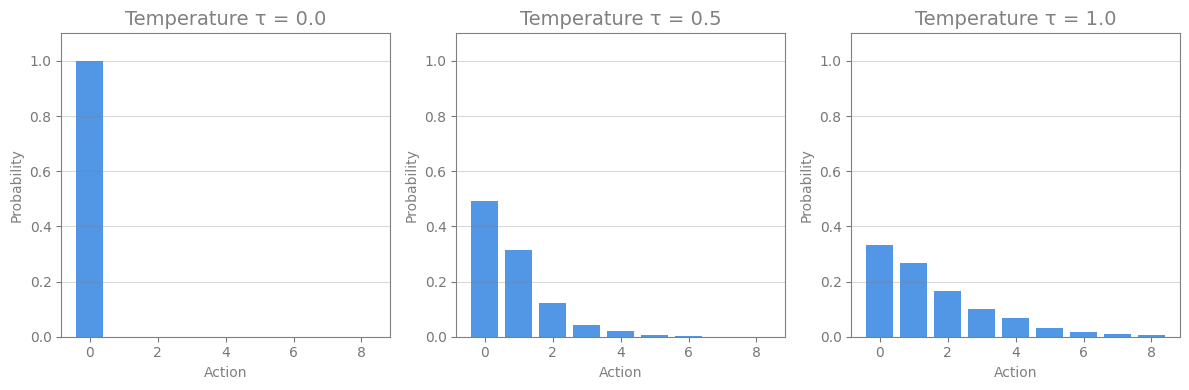

In [17]:
# Demonstration: Temperature effect on move selection
import matplotlib.pyplot as plt

# Simulate visit counts from MCTS
visit_counts = np.array([100, 80, 50, 30, 20, 10, 5, 3, 2])  # 9 possible moves
actions = list(range(9))


def apply_temperature(visit_counts, temperature):
    """Apply temperature to visit counts to get probabilities"""
    if temperature == 0:
        # Greedy: pick most visited
        probs = np.zeros_like(visit_counts, dtype=float)
        probs[np.argmax(visit_counts)] = 1.0
        return probs
    else:
        # Softmax with temperature
        counts_temp = visit_counts ** (1.0 / temperature)
        return counts_temp / np.sum(counts_temp)


# Compare different temperatures
temperatures = [0.0, 0.5, 1.0]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

fig.patch.set_facecolor("none")
for idx, temp in enumerate(temperatures):
    probs = apply_temperature(visit_counts, temp)
    axes[idx].bar(actions, probs, color="#096bda", alpha=0.7)
    axes[idx].set_title(f"Temperature τ = {temp}", fontsize=14, color="#808080")
    axes[idx].set_xlabel("Action", color="#808080")
    axes[idx].set_ylabel("Probability", color="#808080")
    axes[idx].set_ylim(0, 1.1)
    axes[idx].grid(axis="y", alpha=0.3, color="#808080")
    axes[idx].spines["bottom"].set_color("#808080")
    axes[idx].spines["top"].set_color("#808080")
    axes[idx].spines["left"].set_color("#808080")
    axes[idx].spines["right"].set_color("#808080")
    axes[idx].set_facecolor("none")
    axes[idx].tick_params(colors="#777777", which="both")

fig.set_alpha(0)
plt.tight_layout()
plt.show()


**Temperature Annealing Schedule**

In [4]:
def compute_temperature(iteration, move_number):
    # Early iterations: explore more
    if iteration < 100:
        if move_number < 3:
            return 1.0  # High exploration in opening
        else:
            return 0.0  # Deterministic after opening
    else:
        # Later iterations: mostly deterministic
        return 0.0

### 2. Dirichlet Noise: Ensuring Exploration at Root

**Dirichlet noise** is added to the root node's prior probabilities to ensure diverse exploration, especially in the opening phase.

#### The Formula

At the root node only, we modify the prior probabilities:

$$P'(s,a) = (1 - \epsilon) \cdot P(s,a) + \epsilon \cdot \eta_a$$

Where:
- $P(s,a)$ = Neural network's policy output
- $\eta \sim \text{Dir}(\alpha)$ = Dirichlet noise vector
- $\alpha = 0.3$ = Concentration parameter (typical value)
- $\epsilon = 0.25$ = Mixing weight (25% noise, 75% network)

#### Why Dirichlet?

The Dirichlet distribution generates random probability distributions, perfect for adding "controlled randomness" to move selection:

- **Small $\alpha$ (e.g., 0.3)**: Sparse, concentrated distributions (some moves get much more noise)
- **Large $\alpha$ (e.g., 10)**: Uniform-like distributions (all moves get similar noise)

#### Purpose

1. **Prevents determinism**: Even with a strong network, explores suboptimal-looking moves
2. **Finds surprising ideas**: Discovers moves the network initially thinks are bad
3. **Applied only at root**: Child nodes use pure network policy
4. **More exploration early**: Can increase $\epsilon$ in early training iterations

Without Dirichlet Noise: The agent suffers from confirmation bias. It only analyzes moves it already thinks are good, so it struggles to discover new strategies or correct its own misconceptions

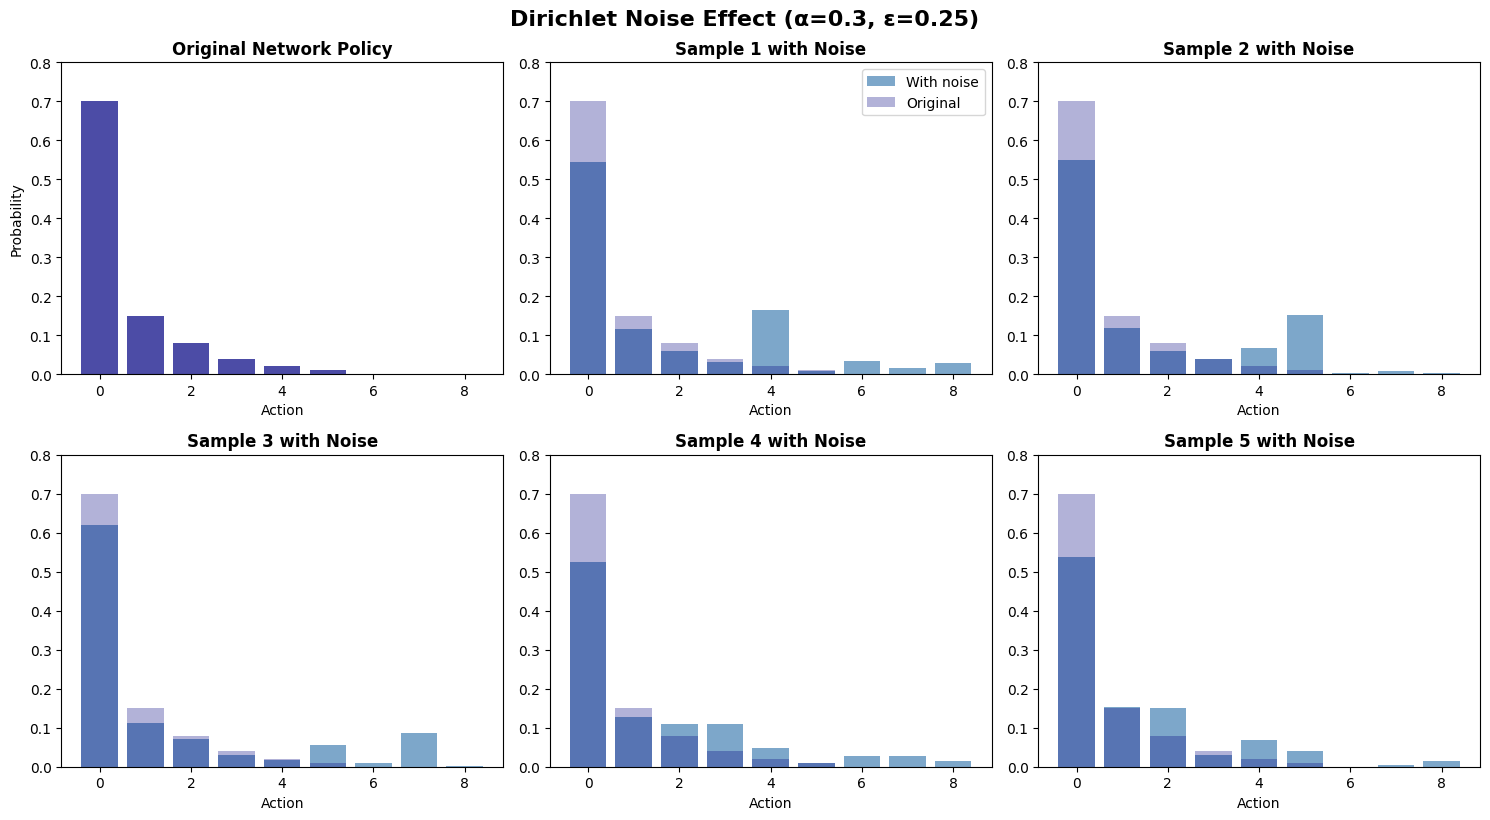

Observations:
  • Network strongly prefers action 0 (70% probability)
  • With noise, other actions get explored
  • Each sample is different (stochastic exploration)
  • Action 0 is still likely, but not guaranteed

  Original best: action 0

Effect of α (concentration parameter):
  α= 0.1: entropy=0.85, max=0.484, min=0.000
  α= 0.3: entropy=1.40, max=0.467, min=0.000
  α= 1.0: entropy=1.86, max=0.250, min=0.025
  α=10.0: entropy=2.15, max=0.172, min=0.072


In [5]:
# Demonstration: Dirichlet noise effect
def apply_dirichlet_noise(policy_probs, alpha=0.3, epsilon=0.25):
    """
    Add Dirichlet noise to policy probabilities

    Args:
        policy_probs: Original policy from neural network
        alpha: Dirichlet concentration parameter
        epsilon: Mixing weight for noise

    Returns:
        Modified policy with noise
    """
    num_actions = len(policy_probs)
    noise = np.random.dirichlet([alpha] * num_actions)
    noisy_policy = (1 - epsilon) * policy_probs + epsilon * noise
    return noisy_policy, noise


# Example: Network suggests a strong preference for action 0
original_policy = np.array([0.7, 0.15, 0.08, 0.04, 0.02, 0.01, 0.0, 0.0, 0.0])

# Apply noise multiple times to see variation
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Original policy
axes[0].bar(range(9), original_policy, color="navy", alpha=0.7)
axes[0].set_title("Original Network Policy", fontsize=12, fontweight="bold")
axes[0].set_ylim(0, 0.8)
axes[0].set_xlabel("Action")
axes[0].set_ylabel("Probability")

# Five samples with noise
for i in range(1, 6):
    noisy_policy, noise = apply_dirichlet_noise(
        original_policy, alpha=0.3, epsilon=0.25
    )
    axes[i].bar(
        range(9), noisy_policy, color="steelblue", alpha=0.7, label="With noise"
    )
    axes[i].bar(range(9), original_policy, color="navy", alpha=0.3, label="Original")
    axes[i].set_title(f"Sample {i} with Noise", fontsize=12, fontweight="bold")
    axes[i].set_ylim(0, 0.8)
    axes[i].set_xlabel("Action")
    if i == 1:
        axes[i].legend()

plt.tight_layout()
plt.suptitle(
    "Dirichlet Noise Effect (α=0.3, ε=0.25)", fontsize=16, fontweight="bold", y=1.02
)
plt.show()

print("Observations:")
print("  • Network strongly prefers action 0 (70% probability)")
print("  • With noise, other actions get explored")
print("  • Each sample is different (stochastic exploration)")
print("  • Action 0 is still likely, but not guaranteed")
print(f"\n  Original best: action {np.argmax(original_policy)}")

# Show how alpha affects noise distribution
print("\n" + "=" * 50)
print("Effect of α (concentration parameter):")
alphas = [0.1, 0.3, 1.0, 10.0]
for alpha in alphas:
    noise = np.random.dirichlet([alpha] * 9)
    print(
        f"  α={alpha:4.1f}: entropy={-np.sum(noise * np.log(noise + 1e-10)):.2f}, "
        f"max={np.max(noise):.3f}, min={np.min(noise):.3f}"
    )

### 3. Replay Buffer: Experience Replay

A **replay buffer** stores training examples from multiple iterations, allowing the network to learn from diverse experiences.

#### Key Concepts

**Problem without replay buffer:**
- Training only on most recent games
- Network quickly overfits to current play style
- Forgets earlier strategic patterns
- Oscillating performance

**Solution with replay buffer:**
- Keep last 50,000 training examples (configurable)
- Sample mini-batches randomly from buffer
- Older examples provide stable learning signal
- Newer examples guide toward stronger play

#### Implementation

```python
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = []
        self.capacity = capacity
    
    def add(self, state, policy, value):
        self.buffer.append((state, policy, value))
        if len(self.buffer) > self.capacity:
            # Remove oldest examples (FIFO)
            self.buffer = self.buffer[-self.capacity:]
    
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]
```

#### Benefits

1. **Breaks correlation**: Consecutive game positions are correlated; random sampling breaks this
2. **Data efficiency**: Reuse examples multiple times across training epochs
3. **Stability**: Older examples prevent catastrophic forgetting
4. **Balance**: Mix of different game phases and board positions

#### Typical Settings

- **Capacity**: 50,000 examples (2D games) to 200,000 (3D games)
- **Retention**: Rolling window, discard oldest when full
- **Sampling**: Uniform random sampling (no prioritization in basic AlphaZero)

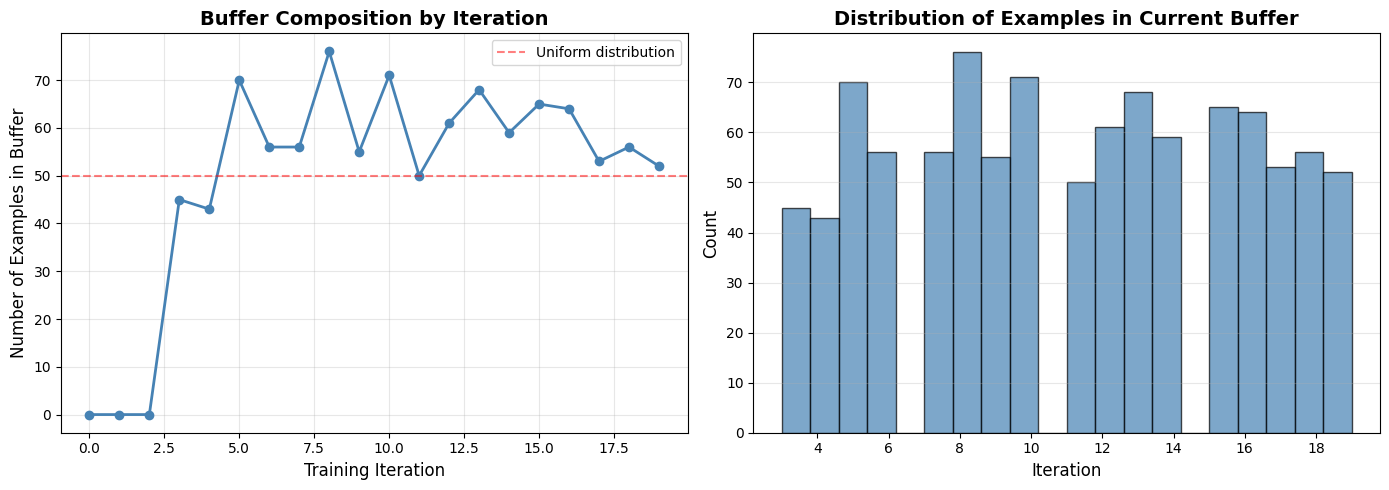

Buffer Statistics:
  Total capacity: 1000
  Current size: 1000
  Oldest example from iteration: 3
  Newest example from iteration: 19
  Iterations represented: 17

Note: Early iterations (0-9) were pushed out as buffer filled.
This ensures we train on recent, stronger play while maintaining diversity.


In [6]:
# Replay Buffer Implementation with Visualization
class ReplayBuffer:
    """Experience replay buffer for training data"""

    def __init__(self, capacity=50000):
        self.buffer = []
        self.capacity = capacity
        self.iteration_markers = []  # Track which iteration examples came from

    def add(self, state, policy, value, iteration=0):
        """Add a training example to the buffer"""
        self.buffer.append((state, policy, value))
        self.iteration_markers.append(iteration)

        # Remove oldest examples when capacity exceeded
        if len(self.buffer) > self.capacity:
            self.buffer = self.buffer[-self.capacity :]
            self.iteration_markers = self.iteration_markers[-self.capacity :]

    def sample(self, batch_size):
        """Sample a random batch from the buffer"""
        if len(self.buffer) < batch_size:
            return self.buffer
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]

    def __len__(self):
        return len(self.buffer)

    def get_iteration_distribution(self):
        """Return histogram of which iterations examples came from"""
        return np.array(self.iteration_markers)


# Simulate buffer filling over training iterations
buffer = ReplayBuffer(capacity=1000)

# Simulate 20 iterations, each adding different amounts
np.random.seed(42)
for iteration in range(20):
    # Each iteration generates 40-80 examples
    num_examples = np.random.randint(40, 80)
    for _ in range(num_examples):
        # Dummy state, policy, value
        state = (tuple(np.random.randint(-1, 2, 9)), 1)
        policy = {i: 1 / 9 for i in range(9)}
        value = np.random.choice([-1, 0, 1])
        buffer.add(state, policy, value, iteration)

# Visualize buffer composition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Buffer size over iterations
sizes = []
for i in range(20):
    count = np.sum(buffer.get_iteration_distribution() == i)
    sizes.append(count)

ax1.plot(range(20), sizes, marker="o", linewidth=2, markersize=6, color="steelblue")
ax1.axhline(
    y=buffer.capacity / 20,
    color="red",
    linestyle="--",
    alpha=0.5,
    label="Uniform distribution",
)
ax1.set_xlabel("Training Iteration", fontsize=12)
ax1.set_ylabel("Number of Examples in Buffer", fontsize=12)
ax1.set_title("Buffer Composition by Iteration", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Histogram of iteration distribution
ax2.hist(
    buffer.get_iteration_distribution(),
    bins=20,
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
)
ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title(
    "Distribution of Examples in Current Buffer", fontsize=14, fontweight="bold"
)
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Buffer Statistics:")
print(f"  Total capacity: {buffer.capacity}")
print(f"  Current size: {len(buffer)}")
print(f"  Oldest example from iteration: {min(buffer.iteration_markers)}")
print(f"  Newest example from iteration: {max(buffer.iteration_markers)}")
print(f"  Iterations represented: {len(set(buffer.iteration_markers))}")
print(f"\nNote: Early iterations (0-9) were pushed out as buffer filled.")
print(f"This ensures we train on recent, stronger play while maintaining diversity.")

### 4. Data Augmentation: Exploiting Symmetries

**Data augmentation** multiplies training data by applying game symmetries. For tic-tac-toe, a position has 8 equivalent forms (rotations and reflections).

#### Why It Works

Board games have **invariances**: rotating or flipping the board doesn't change optimal play. By training on all symmetric versions, we:
- **8x more data** from same number of games
- **Faster learning**: Network learns rotation-invariant features
- **Better generalization**: Prevents memorizing specific board orientations

#### Tic-Tac-Toe Symmetries (Dihedral Group D₄)

8 transformations of the 3×3 grid:
1. **Identity**: No change
2. **Rotate 90°**: Clockwise rotation
3. **Rotate 180°**: Half turn
4. **Rotate 270°**: Counter-clockwise rotation
5-8. **4 Reflections**: Horizontal, vertical, and two diagonal axes

#### Implementation Challenge

When augmenting, must transform **both** the board state and the policy:
- Board state: Permute cell positions
- Policy: Remap action indices to match transformed board

#### Example

Original position:
```
X | O | _
---------
_ | X | _
---------
_ | O | _
```

After 90° rotation:
```
_ | _ | X
---------
O | X | O
---------
_ | _ | _
```

If best action was originally position 2 (top-right), after rotation it becomes position 6 (bottom-middle).

/var/folders/p3/swkn2y6x6sg_cndh1r0084s40000gn/T/ipykernel_29871/2521879894.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


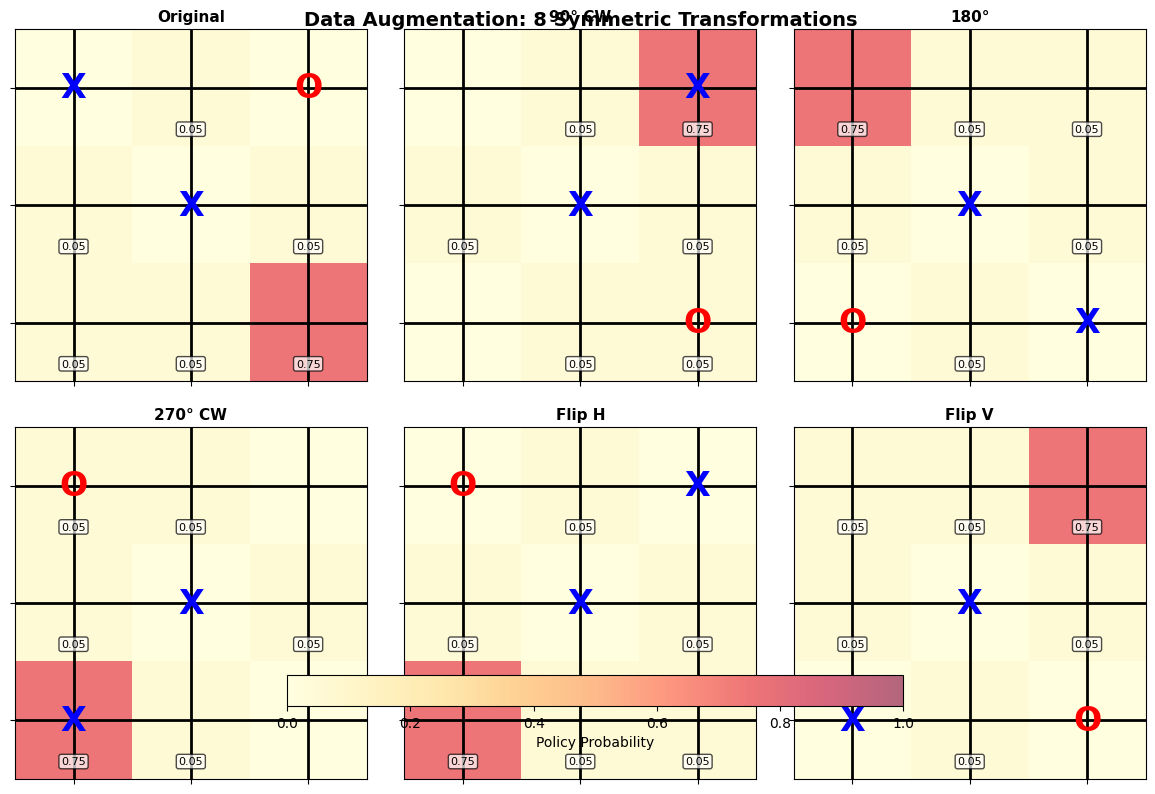

Original example: 1 position
After augmentation: 8 positions
Data multiplication factor: 8x

Key insight: All 8 positions teach the same strategic lesson!
Network learns rotation-invariant patterns faster.


In [7]:
# Data Augmentation: Symmetry transformations for 3x3 board
class SymmetryAugmenter:
    """Generate all 8 symmetric transformations of a tic-tac-toe position"""

    def __init__(self):
        # Pre-compute all 8 permutation mappings
        self.permutations = self._generate_permutations()

    def _generate_permutations(self):
        """Generate 8 permutations for 3x3 board (D4 dihedral group)"""
        perms = []

        # Helper to convert (row, col) to index
        def idx(r, c):
            return r * 3 + c

        # Identity
        identity = list(range(9))
        perms.append(identity)

        # 90° rotation clockwise
        rot90 = [0] * 9
        for r in range(3):
            for c in range(3):
                rot90[idx(c, 2 - r)] = idx(r, c)
        perms.append(rot90)

        # 180° rotation
        rot180 = [0] * 9
        for r in range(3):
            for c in range(3):
                rot180[idx(2 - r, 2 - c)] = idx(r, c)
        perms.append(rot180)

        # 270° rotation (or 90° counter-clockwise)
        rot270 = [0] * 9
        for r in range(3):
            for c in range(3):
                rot270[idx(2 - c, r)] = idx(r, c)
        perms.append(rot270)

        # Horizontal flip
        flip_h = [0] * 9
        for r in range(3):
            for c in range(3):
                flip_h[idx(r, 2 - c)] = idx(r, c)
        perms.append(flip_h)

        # Vertical flip
        flip_v = [0] * 9
        for r in range(3):
            for c in range(3):
                flip_v[idx(2 - r, c)] = idx(r, c)
        perms.append(flip_v)

        # Diagonal flip (main diagonal)
        flip_d1 = [0] * 9
        for r in range(3):
            for c in range(3):
                flip_d1[idx(c, r)] = idx(r, c)
        perms.append(flip_d1)

        # Anti-diagonal flip
        flip_d2 = [0] * 9
        for r in range(3):
            for c in range(3):
                flip_d2[idx(2 - c, 2 - r)] = idx(r, c)
        perms.append(flip_d2)

        return perms

    def augment(self, state, policy_dict, value):
        """
        Generate all 8 symmetric versions of a training example

        Args:
            state: (board_tuple, player)
            policy_dict: {action: probability}
            value: outcome value

        Returns:
            List of 8 augmented examples
        """
        board, player = state
        augmented = []

        for perm in self.permutations:
            # Transform board
            new_board = [board[perm[i]] for i in range(9)]

            # Transform policy: action i in original -> perm[i] in transformed
            new_policy = {}
            for action, prob in policy_dict.items():
                new_action = perm[action]
                new_policy[new_action] = prob

            augmented.append(((tuple(new_board), player), new_policy, value))

        return augmented


# Demonstration
augmenter = SymmetryAugmenter()

# Example position: X has two in a row
board = [
    1,
    0,
    -1,  # X _ O
    0,
    1,
    0,  # _ X _
    0,
    0,
    0,  # _ _ _
]
player = -1  # O to move

# Policy: O should block at position 8 (bottom-right completes diagonal)
policy = {0: 0.0, 1: 0.05, 2: 0.0, 3: 0.05, 4: 0.0, 5: 0.05, 6: 0.05, 7: 0.05, 8: 0.75}
value = -1  # O wins if plays correctly

# Generate augmentations
original_example = ((tuple(board), player), policy, value)
augmented_examples = augmenter.augment((tuple(board), player), policy, value)

# Visualize original and first 4 augmentations
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()


def draw_board(ax, board, policy, title):
    """Draw a tic-tac-toe board with policy heatmap"""
    board_array = np.array(board).reshape(3, 3)

    # Create policy grid
    policy_grid = np.zeros((3, 3))
    for action, prob in policy.items():
        policy_grid[action // 3, action % 3] = prob

    # Draw heatmap
    im = ax.imshow(policy_grid, cmap="YlOrRd", alpha=0.6, vmin=0, vmax=1)

    # Draw X and O
    for i in range(3):
        for j in range(3):
            val = board_array[i, j]
            if val == 1:
                ax.text(
                    j,
                    i,
                    "X",
                    ha="center",
                    va="center",
                    fontsize=24,
                    fontweight="bold",
                    color="blue",
                )
            elif val == -1:
                ax.text(
                    j,
                    i,
                    "O",
                    ha="center",
                    va="center",
                    fontsize=24,
                    fontweight="bold",
                    color="red",
                )
            # Show policy probability
            prob = policy_grid[i, j]
            if prob > 0.01:
                ax.text(
                    j,
                    i + 0.35,
                    f"{prob:.2f}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="black",
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, pad=0.2),
                )

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, linewidth=2, color="black")
    ax.set_title(title, fontsize=11, fontweight="bold")

    return im


# Draw original and augmentations
transform_names = ["Original", "90° CW", "180°", "270° CW", "Flip H", "Flip V"]
for idx in range(6):
    if idx < len(augmented_examples):
        state, pol, val = augmented_examples[idx]
        board, player = state
        draw_board(axes[idx], board, pol, transform_names[idx])

# Add colorbar
fig.colorbar(
    axes[0].images[0],
    ax=axes,
    orientation="horizontal",
    pad=0.05,
    fraction=0.05,
    label="Policy Probability",
)

plt.tight_layout()
plt.suptitle(
    "Data Augmentation: 8 Symmetric Transformations",
    fontsize=14,
    fontweight="bold",
    y=0.98,
)
plt.show()

print(f"Original example: 1 position")
print(f"After augmentation: {len(augmented_examples)} positions")
print(f"Data multiplication factor: {len(augmented_examples)}x")
print(f"\nKey insight: All 8 positions teach the same strategic lesson!")
print(f"Network learns rotation-invariant patterns faster.")

### Putting It All Together: Enhanced Self-Play

Now let's integrate all four techniques into our self-play implementation.

In [8]:
# Simple Tic-Tac-Toe game implementation for demonstration
class TicTacToe:
    def __init__(self):
        self.board = [0] * 9  # 0=empty, 1=X, -1=O
        self.current_player = 1

    def copy(self):
        """Create a copy of the game"""
        new_game = TicTacToe()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        return new_game

    def state(self):
        """Return state as (board_tuple, player)"""
        return (tuple(self.board), self.current_player)

    def valid_moves(self):
        """Return list of valid moves"""
        return [i for i in range(9) if self.board[i] == 0]

    def make_move(self, action):
        """Make a move"""
        if self.board[action] != 0:
            raise ValueError(f"Invalid move: {action}")
        self.board[action] = self.current_player
        self.current_player = -self.current_player

    def over(self):
        """Check if game is over"""
        return self.score() != 0 or len(self.valid_moves()) == 0

    def score(self):
        """Return 1 if X wins, -1 if O wins, 0 otherwise"""
        lines = [
            [0, 1, 2],
            [3, 4, 5],
            [6, 7, 8],  # rows
            [0, 3, 6],
            [1, 4, 7],
            [2, 5, 8],  # columns
            [0, 4, 8],
            [2, 4, 6],  # diagonals
        ]
        for line in lines:
            if self.board[line[0]] == self.board[line[1]] == self.board[line[2]] != 0:
                return self.board[line[0]]
        return 0


print("✓ TicTacToe game class defined")

✓ TicTacToe game class defined


In [9]:
def play_one_self_play_game_enhanced(
    game_class,
    model,
    num_simulations=100,
    iteration=0,
    use_dirichlet=True,
    alpha=0.3,
    epsilon=0.25,
):
    """
    Play one complete self-play game with all enhancements

    Args:
        game_class: Game class to instantiate (e.g., TicTacToe)
        model: AlphaZeroModel instance
        num_simulations: Number of MCTS simulations per move
        iteration: Current training iteration (for temperature annealing)
        use_dirichlet: Whether to add Dirichlet noise at root
        alpha: Dirichlet concentration parameter
        epsilon: Dirichlet mixing weight

    Returns:
        List of training examples: [(state, policy_dict, outcome), ...]
    """
    game = game_class()

    # Create MCTS with Dirichlet noise support
    class EnhancedMCTS(AlphaZeroMCTS):
        def search_with_noise(self, root_state, add_noise=True):
            """MCTS search with optional Dirichlet noise at root"""
            root = MCTSNode(root_state)

            # Expand root
            game_copy_root = self.game.copy()
            if not game_copy_root.over():
                v_root, policy_root = self.model.predict(game_copy_root)
                legal = game_copy_root.valid_moves()
                probs = [(a, policy_root[a]) for a in legal]
                s = sum(p for _, p in probs)
                if s > 0:
                    probs = [(a, p / s) for a, p in probs]

                # Add Dirichlet noise if requested
                if add_noise and probs:
                    noise = np.random.dirichlet([alpha] * len(probs))
                    probs = [
                        (a, (1 - epsilon) * p + epsilon * n)
                        for (a, p), n in zip(probs, noise)
                    ]

                root.expand(game_copy_root, probs)

            # Run simulations (same as before)
            for _ in range(self.num_simulations):
                node = root
                game_copy = self.game.copy()

                while node.is_expanded() and not game_copy.over():
                    node = node.select_child(self.c_puct)
                    game_copy.make_move(node.action)

                if not game_copy.over():
                    v, policy = self.model.predict(game_copy)
                    legal = game_copy.valid_moves()
                    probs = [(a, policy[a]) for a in legal]
                    s = sum(p for _, p in probs)
                    if s > 0:
                        probs = [(a, p / s) for a, p in probs]
                    node.expand(game_copy, probs)
                    node.backup(v)
                else:
                    terminal_v = game_copy.score() * game_copy.current_player
                    node.backup(terminal_v)

            return root

    mcts = EnhancedMCTS(game, model, num_simulations=num_simulations)
    training_examples = []
    move_index = 0

    while not game.over():
        current_player = game.current_player

        # Temperature annealing
        if move_index < 3 and iteration < 100:
            temperature = 1.0  # High exploration in opening
        else:
            temperature = 0.0  # Deterministic play

        # Run MCTS with noise on first move only
        root = mcts.search_with_noise(
            game.state(), add_noise=(use_dirichlet and move_index == 0)
        )

        # Get action probabilities with temperature
        actions = []
        visit_counts = []
        for action, child in root.children.items():
            actions.append(action)
            visit_counts.append(child.visit_count)

        if temperature == 0:
            probs = np.zeros(len(actions))
            probs[np.argmax(visit_counts)] = 1.0
        else:
            visit_counts = np.array(visit_counts)
            visit_counts = visit_counts ** (1.0 / temperature)
            probs = visit_counts / np.sum(visit_counts)

        # Record example
        training_examples.append(
            {
                "state": (game.state(), current_player),
                "policy": dict(zip(actions, probs)),
                "value": None,
                "player": current_player,
            }
        )

        # Sample and make move
        action = np.random.choice(actions, p=probs)
        game.make_move(action)
        move_index += 1

    # Assign final outcome
    game_result = game.score()
    for example in training_examples:
        example["value"] = game_result * example["player"]

    return [(ex["state"], ex["policy"], ex["value"]) for ex in training_examples]


# Compare self-play with and without enhancements
print("=" * 60)
print("Self-Play Comparison")
print("=" * 60)

model = AlphaZeroModel(board_size=3, action_size=9)

# Without enhancements
print("\n1. Basic self-play (no Dirichlet noise):")
examples_basic = play_one_self_play_game_enhanced(
    TicTacToe, model, num_simulations=30, iteration=0, use_dirichlet=False
)
print(f"   Generated {len(examples_basic)} examples")

# With enhancements
print("\n2. Enhanced self-play (with Dirichlet noise):")
examples_enhanced = play_one_self_play_game_enhanced(
    TicTacToe, model, num_simulations=30, iteration=0, use_dirichlet=True
)
print(f"   Generated {len(examples_enhanced)} examples")

print("\n" + "=" * 60)
print("✓ Enhanced self-play function ready")
print(
    "  Includes: Temperature, Dirichlet noise, ready for replay buffer & augmentation"
)
print("=" * 60)

Self-Play Comparison

1. Basic self-play (no Dirichlet noise):
   Generated 5 examples

2. Enhanced self-play (with Dirichlet noise):
   Generated 8 examples

✓ Enhanced self-play function ready
  Includes: Temperature, Dirichlet noise, ready for replay buffer & augmentation


## Part 4: Training Loop

The complete AlphaZero training process repeats these steps:

### One Training Iteration

1. **Generate self-play games** (100-1000 games)
   - Each game uses current neural network + MCTS
   - Record all positions, MCTS policies, and outcomes

2. **Data augmentation** (optional)
   - Apply symmetries (rotations, reflections) to multiply data
   - For tic-tac-toe: 8 symmetries per position

3. **Train neural network**
   - Sample mini-batches from replay buffer
   - Minimize combined loss:
     - Policy loss: Cross-entropy between MCTS policy and network policy
     - Value loss: MSE between game outcome and network value prediction

4. **Evaluation** (periodic)
   - Play against previous checkpoints
   - Track Elo rating or win rate

5. **Save checkpoint** and repeat

### Key Hyperparameters

From `main.py` and `qubic.py`:

```python
N_ITERATIONS = 200          # Number of training iterations
N_GAMES = 100               # Self-play games per iteration
N_SIMULATIONS = 100         # MCTS simulations per move
C_PUCT = 1.0                # Exploration constant
BATCH_SIZE = 64             # Training batch size
EPOCHS = 10                 # Training epochs per iteration
LEARNING_RATE = 0.001       # Neural network learning rate
REPLAY_CAPACITY = 50000     # Max samples in replay buffer
```

### The Virtuous Cycle

```
Better Network → Better MCTS → Better Training Data → Better Network
```

- **Initially**: Random network, MCTS explores randomly
- **After 10 iterations**: Network learns basic patterns (winning lines, blocking)
- **After 50 iterations**: Network plays strong opening theory
- **After 100+ iterations**: Near-optimal play, beats humans easily

In [10]:
def train_alphazero_complete(
    game_class,
    model,
    num_iterations=10,
    games_per_iteration=20,
    use_augmentation=True,
    replay_capacity=5000,
):
    """
    Complete AlphaZero training loop with all enhancements

    Args:
        game_class: Game class (e.g., TicTacToe)
        model: AlphaZeroModel instance
        num_iterations: Number of training iterations
        games_per_iteration: Self-play games per iteration
        use_augmentation: Whether to use symmetry augmentation
        replay_capacity: Maximum size of replay buffer
    """
    print("=" * 70)
    print("AlphaZero Training Loop (Complete with All Enhancements)")
    print("=" * 70)

    # Initialize replay buffer and augmenter
    replay_buffer = ReplayBuffer(capacity=replay_capacity)
    augmenter = SymmetryAugmenter() if use_augmentation else None

    stats = {"raw_examples": [], "augmented_examples": [], "buffer_sizes": []}

    for iteration in range(num_iterations):
        print(f"\n{'=' * 70}")
        print(f"📊 Iteration {iteration + 1}/{num_iterations}")
        print(f"{'=' * 70}")

        # Step 1: Self-play with all enhancements
        print(f"  🎮 Playing {games_per_iteration} self-play games...")
        print(
            f"     • Temperature annealing: {'ON' if iteration < 100 else 'OFF (deterministic)'}"
        )
        print(f"     • Dirichlet noise (α=0.3, ε=0.25): ON")

        iteration_examples = []
        for game_num in range(games_per_iteration):
            examples = play_one_self_play_game_enhanced(
                game_class,
                model,
                num_simulations=50,
                iteration=iteration,
                use_dirichlet=True,
                alpha=0.3,
                epsilon=0.25,
            )
            iteration_examples.extend(examples)

        raw_count = len(iteration_examples)
        stats["raw_examples"].append(raw_count)
        print(f"  ✓ Generated {raw_count} raw training examples")

        # Step 2: Data augmentation
        augmented_examples = []
        if use_augmentation:
            print(f"  🔄 Applying symmetry augmentation (8x multiplier)...")
            for state, policy, value in iteration_examples:
                aug_examples = augmenter.augment(state, policy, value)
                augmented_examples.extend(aug_examples)
            print(
                f"  ✓ Augmented to {len(augmented_examples)} examples ({len(augmented_examples) / raw_count:.1f}x)"
            )
        else:
            augmented_examples = iteration_examples
            print(f"  ⊗ Augmentation disabled")

        stats["augmented_examples"].append(len(augmented_examples))

        # Step 3: Add to replay buffer
        print(f"  💾 Adding to replay buffer...")
        for state, policy, value in augmented_examples:
            replay_buffer.add(state, policy, value, iteration)

        buffer_size = len(replay_buffer)
        stats["buffer_sizes"].append(buffer_size)
        print(f"  ✓ Replay buffer size: {buffer_size}/{replay_capacity}")

        # Step 4: Train on replay buffer
        print(f"  🧠 Training neural network on replay buffer...")

        # Sample from buffer and train
        if buffer_size >= 32:
            batch = replay_buffer.sample(min(buffer_size, 256))
            for state, policy, value in batch:
                model.add_training_data(state, policy, value)

            model.train(batch_size=32, epochs=3)
            print(f"  ✓ Trained on {min(buffer_size, 256)} samples from buffer")
        else:
            print(f"  ⚠ Buffer too small ({buffer_size} < 32), skipping training")

        # Step 5: Progress report
        if (iteration + 1) % 5 == 0 or iteration == num_iterations - 1:
            print(f"\n  {'─' * 66}")
            print(f"  📈 Checkpoint Summary (Iteration {iteration + 1})")
            print(f"  {'─' * 66}")
            print(f"     Raw examples this iter:     {raw_count}")
            print(f"     Augmented examples:         {len(augmented_examples)}")
            print(f"     Total in replay buffer:     {buffer_size}")
            print(
                f"     Augmentation multiplier:    {len(augmented_examples) / raw_count:.1f}x"
            )

            # Show buffer age distribution
            ages = replay_buffer.get_iteration_distribution()
            oldest = min(ages) if len(ages) > 0 else iteration
            newest = max(ages) if len(ages) > 0 else iteration
            print(f"     Buffer age range:           iter {oldest} to {newest}")
            print(f"  {'─' * 66}")

    print("\n" + "=" * 70)
    print("✅ Training Complete!")
    print("=" * 70)

    # Final statistics
    print("\nFinal Statistics:")
    print(f"  Total raw examples generated:   {sum(stats['raw_examples'])}")
    print(f"  Total augmented examples:       {sum(stats['augmented_examples'])}")
    print(f"  Final buffer size:              {stats['buffer_sizes'][-1]}")
    print(
        f"  Average augmentation factor:    {sum(stats['augmented_examples']) / sum(stats['raw_examples']):.1f}x"
    )

    return model, stats


# Run complete training demonstration
print("Starting complete training run with all enhancements...")
print("(5 iterations, 10 games per iteration)\n")

model = AlphaZeroModel(board_size=3, action_size=9, learning_rate=0.001)
trained_model, training_stats = train_alphazero_complete(
    TicTacToe,
    model,
    num_iterations=5,
    games_per_iteration=10,
    use_augmentation=True,
    replay_capacity=1000,
)

# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, 6)
ax1.plot(
    iterations,
    training_stats["raw_examples"],
    marker="o",
    label="Raw examples",
    linewidth=2,
)
ax1.plot(
    iterations,
    training_stats["augmented_examples"],
    marker="s",
    label="After augmentation",
    linewidth=2,
)
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Number of Examples", fontsize=12)
ax1.set_title("Training Data Generation", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(
    iterations,
    training_stats["buffer_sizes"],
    marker="o",
    color="steelblue",
    linewidth=2,
)
ax2.axhline(y=1000, color="red", linestyle="--", alpha=0.5, label="Capacity")
ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("Buffer Size", fontsize=12)
ax2.set_title("Replay Buffer Growth", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ Complete training demonstration finished!")
print("   All four techniques demonstrated:")
print("   ✓ Temperature annealing")
print("   ✓ Dirichlet noise")
print("   ✓ Replay buffer")
print("   ✓ Data augmentation")
print("=" * 70)

Starting complete training run with all enhancements...
(5 iterations, 10 games per iteration)

AlphaZero Training Loop (Complete with All Enhancements)

📊 Iteration 1/5
  🎮 Playing 10 self-play games...
     • Temperature annealing: ON
     • Dirichlet noise (α=0.3, ε=0.25): ON
  ✓ Generated 84 raw training examples
  🔄 Applying symmetry augmentation (8x multiplier)...


IndexError: tuple index out of range

## Part 5: Why Self-Play Works

### The Teacher-Student Relationship

**MCTS acts as the "teacher"**: It does deep lookahead (100+ simulations) to find good moves, but it's slow.

**Neural Network acts as the "student"**: It learns to mimic MCTS instantly (one forward pass), but initially knows nothing.

Through self-play:
- MCTS provides high-quality move probabilities $\pi$ (visit counts)
- Neural network learns to predict these directly from the position
- As the network improves, MCTS becomes even stronger (better evaluations)
- This creates a positive feedback loop

### Why Not Just Use MCTS?

MCTS alone works but is slow:
- 100 simulations per move
- Each simulation evaluates multiple positions

Neural network after training:
- One forward pass per move (milliseconds)
- Distills 100s of simulations into learned patterns
- Can still use MCTS for critical decisions (tournament play)

### Key Insights from Research

1. **Self-play is sufficient**: No human data needed
2. **MCTS + NN > MCTS alone**: The combination is stronger than either part
3. **Iterative improvement**: Each iteration makes both components better
4. **Generalization**: Network learns general principles, not just memorization


### Summary: Four Essential Techniques

| Technique | Purpose | When Applied | Key Parameters |
|-----------|---------|--------------|----------------|
| **Temperature** | Control exploration vs exploitation | Every move selection | τ=1.0 (early moves), τ=0.0 (later) |
| **Dirichlet Noise** | Force exploration at root | Root node expansion only | α=0.3, ε=0.25 |
| **Replay Buffer** | Reuse training data, prevent forgetting | Store all examples | Capacity: 50K |
| **Data Augmentation** | Multiply data via symmetries | After game completion | 8x for 3x3, 24-48x for 3D |

#### Impact on Training

```
Without Enhancements:
  100 games/iter × 9 moves/game = 900 examples
  Train only on current iteration
  → Slow learning, overfitting

With All Enhancements:
  100 games/iter × 9 moves/game × 8 (augmentation) = 7,200 examples
  Train on last 50,000 examples from multiple iterations
  Diverse openings from Dirichlet noise
  Smart exploration from temperature annealing
  → Fast, stable learning
```

#### In the Real Implementation

From `main.py` (lines 628-700):
```python
def self_play_game(self, iteration: int):
    # Temperature: compute per move
    temp = self._compute_temperature(iteration, move_index)
    
    # Dirichlet noise: added in MCTS.search() at root
    # alpha=0.3, eps=0.25
    
    # Replay buffer: self.model.training_data (capacity 50K)
    
    # Augmentation: self._augment_examples()
    # Returns 8x examples for 3x3 board
```

These four techniques transform AlphaZero from a theoretical idea into a practical, high-performance learning system!

## Summary: The AlphaZero Self-Play Pipeline

### Components

1. **Game Environment** (TicTacToe, Qubic/3D, etc.)
   - Defines legal moves, win conditions, board representation
   - Must support: `copy()`, `make_move()`, `over()`, `score()`

2. **Neural Network** (AlphaZeroNet)
   - Input: Board state as multi-channel tensor
   - Output: Policy (move probabilities) + Value (position evaluation)
   - Architecture: Conv layers + Residual blocks + Two heads

3. **MCTS** (AlphaZeroMCTS)
   - Runs simulations guided by neural network
   - Uses PUCT formula to balance exploration/exploitation
   - Produces visit count distribution (training target)

4. **Self-Play Loop**
   - Plays games using MCTS + network
   - Records (state, policy, outcome) triples
   - Trains network to match MCTS outputs

### The Complete Cycle

```
┌─────────────────────────────────────────────────────┐
│                 Initialize Network                   │
│              (random weights initially)              │
└────────────────────┬────────────────────────────────┘
                     │
                     ▼
         ┌───────────────────────┐
         │  Training Iteration   │
         └───────────┬───────────┘
                     │
        ┌────────────┴────────────┐
        │                          │
        ▼                          │
┌───────────────┐                 │
│   Self-Play   │                 │
│  (N games)    │                 │
└───────┬───────┘                 │
        │                          │
        │ training data            │
        ▼                          │
┌───────────────┐                 │
│ Replay Buffer │                 │
│ (50k samples) │                 │
└───────┬───────┘                 │
        │                          │
        │ sample batches           │
        ▼                          │
┌───────────────┐                 │
│ Train Network │                 │
│ (10 epochs)   │                 │
└───────┬───────┘                 │
        │                          │
        │ updated weights          │
        └──────────────────────────┘
```

### Key Takeaways for Teaching

1. **Self-play eliminates need for human data**: The system creates its own curriculum

2. **MCTS provides the "ground truth"**: Deep search finds better moves than the network alone

3. **Network distills search into intuition**: Learns patterns that would take thousands of simulations

4. **Iterative improvement**: Each cycle produces better data for the next cycle

5. **Scalability**: Same algorithm works for tic-tac-toe, chess, Go, and Qubic

This is the core innovation of AlphaZero: combining deep learning (pattern recognition) with classical search (lookahead) in a self-improving loop.

## References & Further Exploration

### Code References in This Repository

- **`2d/main.py`**: Complete AlphaZero implementation for 3x3 tic-tac-toe
  - `self_play_game()`: Single game generation (line 628)
  - `train_iteration()`: Full iteration with parallel self-play (line 652)
  - MCTS implementation: `AlphaZeroMCTS` class
  - Network: `AlphaZeroNet` with residual blocks

- **`3d/qubic.py`**: 4x4x4 3D tic-tac-toe (Qubic)
  - 3D convolutional network
  - Symmetry augmentation (24-48 transformations)
  - Elo rating tournament system

- **`teach/notebooks/mcts.ipynb`**: Interactive MCTS visualizations
- **`teach/notebooks/nn.ipynb`**: Neural network architecture details

### Research Papers

- **AlphaGo Zero**: "Mastering the game of Go without human knowledge" (Silver et al., 2017)
- **AlphaZero**: "A general reinforcement learning algorithm that masters chess, shogi, and Go through self-play" (Silver et al., 2018)

### Key Hyperparameters from Our Implementation

```python
# Training scale
N_ITERATIONS = 200          # Total training iterations
N_GAMES = 100-200          # Games per iteration
N_SIMULATIONS = 100        # MCTS sims per move

# MCTS
C_PUCT = 1.0               # Exploration constant
TEMPERATURE_INITIAL = 1.0   # Early game exploration
TEMPERATURE_FINAL = 0.0     # Late game exploitation

# Neural network
CHANNELS = 64              # Conv channels (2D) or 32 (3D)
NUM_RES_BLOCKS = 4         # Residual blocks
LEARNING_RATE = 0.001      # Adam/AdamW learning rate
BATCH_SIZE = 64            # Training batch size
EPOCHS = 10                # Epochs per iteration

# Data
REPLAY_CAPACITY = 50000    # Max training examples stored
SYMMETRY_AUGMENT = True    # Use rotations/reflections
```